# Distribution des continents dans le temps 

Dans ce carnet est proposée une analyse de la distribution dans le temps des continents relatifs aux pays d'appartenance, en relation aux années de naissance de la population retenue.


In [4]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [5]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [6]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [7]:
## define SPARQL enpoint
endpoint = "https://ag10gz6eypmkc7tx.allegrograph.cloud/repositories/novelists"

In [8]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            (MAX(?gen) as ?gen) ( GROUP_CONCAT(?continentLabel; separator=", ") AS ?onctinents )
WHERE {
    GRAPH <https://github.com/mariaponomarova/novelists/blob/main/Wikidata/graph/imported-data.md>
        {?s wdt:P21 ?gen;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        ## Excluding Eurasia, Australia and Oceania insular
        FILTER ( ?continent NOT IN (wd:Q538, wd:Q3960, wd:Q5401))
          }
}
GROUP BY ?s
"""

In [9]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [10]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

33326


[['http://www.wikidata.org/entity/Q1679958',
  'James Anthony Froude',
  '1818',
  'http://www.wikidata.org/entity/Q6581097',
  'Europe'],
 ['http://www.wikidata.org/entity/Q6795407',
  'Max Yoho',
  '1934',
  'http://www.wikidata.org/entity/Q6581097',
  'North America'],
 ['http://www.wikidata.org/entity/Q18117982',
  'Louis Wuarin',
  '1846',
  'http://www.wikidata.org/entity/Q6581097',
  'Europe']]

In [11]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'genderUri', 'continents']
df_p.head()

,personUri,personLabel,birthYear,genderUri,continents
0,http://www.wikidata.org/entity/Q1679958,James Anthony Froude,1818,http://www.wikidata.org/entity/Q6581097,Europe
1,http://www.wikidata.org/entity/Q6795407,Max Yoho,1934,http://www.wikidata.org/entity/Q6581097,North America
2,http://www.wikidata.org/entity/Q18117982,Louis Wuarin,1846,http://www.wikidata.org/entity/Q6581097,Europe
3,http://www.wikidata.org/entity/Q2896572,Benoît Lemaire,1929,http://www.wikidata.org/entity/Q6581097,North America
4,http://www.wikidata.org/entity/Q132852885,Q132852885,1903,http://www.wikidata.org/entity/Q6581097,Asia


In [12]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33326 entries, 0 to 33325
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    33326 non-null  object
 1   personLabel  33326 non-null  object
 2   birthYear    33326 non-null  object
 3   genderUri    33326 non-null  object
 4   continents   33326 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


## Coder les continents et afficher leur distribution

In [13]:
def codeContinents(continents):
    listContinents = sorted(continents.split(','))
    if 'Europe' in listContinents:
        output = 'Europe'
    elif 'Asia' in listContinents:
        output = 'Asia'
    elif 'Africa' in listContinents:
        output = 'Africa'
    elif 'Oceania' in listContinents:
        output = 'Oceania'   
    elif 'North America' in listContinents:
        output = 'NorthAmerica'   
    elif 'South America' in listContinents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [14]:
codeContinents('Oceania, North America, Africa')

'Oceania'

In [15]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,genderUri,continents,contCode
0,http://www.wikidata.org/entity/Q1679958,James Anthony Froude,1818,http://www.wikidata.org/entity/Q6581097,Europe,Europe
1,http://www.wikidata.org/entity/Q6795407,Max Yoho,1934,http://www.wikidata.org/entity/Q6581097,North America,NorthAmerica
2,http://www.wikidata.org/entity/Q18117982,Louis Wuarin,1846,http://www.wikidata.org/entity/Q6581097,Europe,Europe


In [16]:
df_p.iloc[ 115:120 :  ]

,personUri,personLabel,birthYear,genderUri,continents,contCode
115,http://www.wikidata.org/entity/Q11668806,Teru Takakura,1891,http://www.wikidata.org/entity/Q6581097,"Asia, Asia",Asia
116,http://www.wikidata.org/entity/Q87331220,Edward Goodwin Ballard,1910,http://www.wikidata.org/entity/Q6581097,North America,NorthAmerica
117,http://www.wikidata.org/entity/Q19513413,Manfred Sommer,1945,http://www.wikidata.org/entity/Q6581097,Europe,Europe
118,http://www.wikidata.org/entity/Q4766979,Anna Eliza Bray,1790,http://www.wikidata.org/entity/Q6581072,"Europe, Europe",Europe
119,http://www.wikidata.org/entity/Q271111,Mary Stewart,1916,http://www.wikidata.org/entity/Q6581072,Europe,Europe


In [17]:


### Regrouper et compter
df_p = df_p[df_p['contCode'] != 'Missing']
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Oceania            455
Africa             476
SouthAmerica      1166
Asia              4564
NorthAmerica      8496
Europe           18168


In [18]:


df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
Oceania,455,1.37
Africa,476,1.43
SouthAmerica,1166,3.50
Asia,4564,13.70
NorthAmerica,8496,25.49
Europe,18168,54.52


In [19]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,Europe,NorthAmerica,Asia,SouthAmerica,Africa,Oceania
frequence,54.52,25.49,13.7,3.5,1.43,1.37


In [49]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique


col_palette = [
    "#FF9EB5",  # Baker-Miller Pink (soft pastel)  
    "#FF6B8B",  # Light Crimson (warm pink)
    "#FFACD5",  # Cotton Candy (lightest pink)
    "#A2E4B8",  # Mint Green (fresh contrast)
    "#FFD166",  # Pastel Yellow (sunny accent)
    "#8BD3E6"   # Sky Blue (cool balance)
]


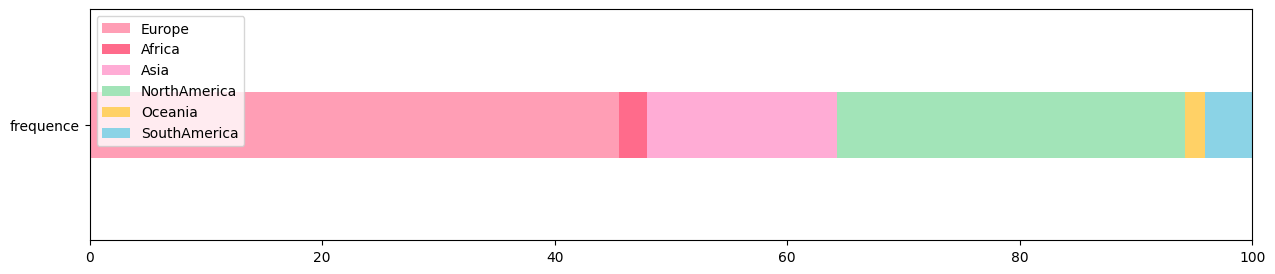

In [50]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [22]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 1976, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1851, 1876, 1901, 1926, 1951] 8


In [23]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [24]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,genderUri,continents,contCode,per_25
0,http://www.wikidata.org/entity/Q1679958,James Anthony Froude,1818,http://www.wikidata.org/entity/Q6581097,Europe,Europe,1801-1825
1,http://www.wikidata.org/entity/Q6795407,Max Yoho,1934,http://www.wikidata.org/entity/Q6581097,North America,NorthAmerica,1926-1950
2,http://www.wikidata.org/entity/Q18117982,Louis Wuarin,1846,http://www.wikidata.org/entity/Q6581097,Europe,Europe,1826-1850


In [25]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25').size()
print(naissances_per)

per_25
1751-1775      478
1776-1800      626
1801-1825     1293
1826-1850     1830
1851-1875     3044
1876-1900     4636
1901-1925     7332
1926-1950    14086
dtype: int64


/var/folders/b5/yh6_b6cs4vgfqd16nkxmhl9h0000gn/T/ipykernel_32866/173774721.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  naissances_per = df_p.groupby(by='per_25').size()


/var/folders/b5/yh6_b6cs4vgfqd16nkxmhl9h0000gn/T/ipykernel_32866/2527900628.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df_p.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8), color='#FF6B8B')


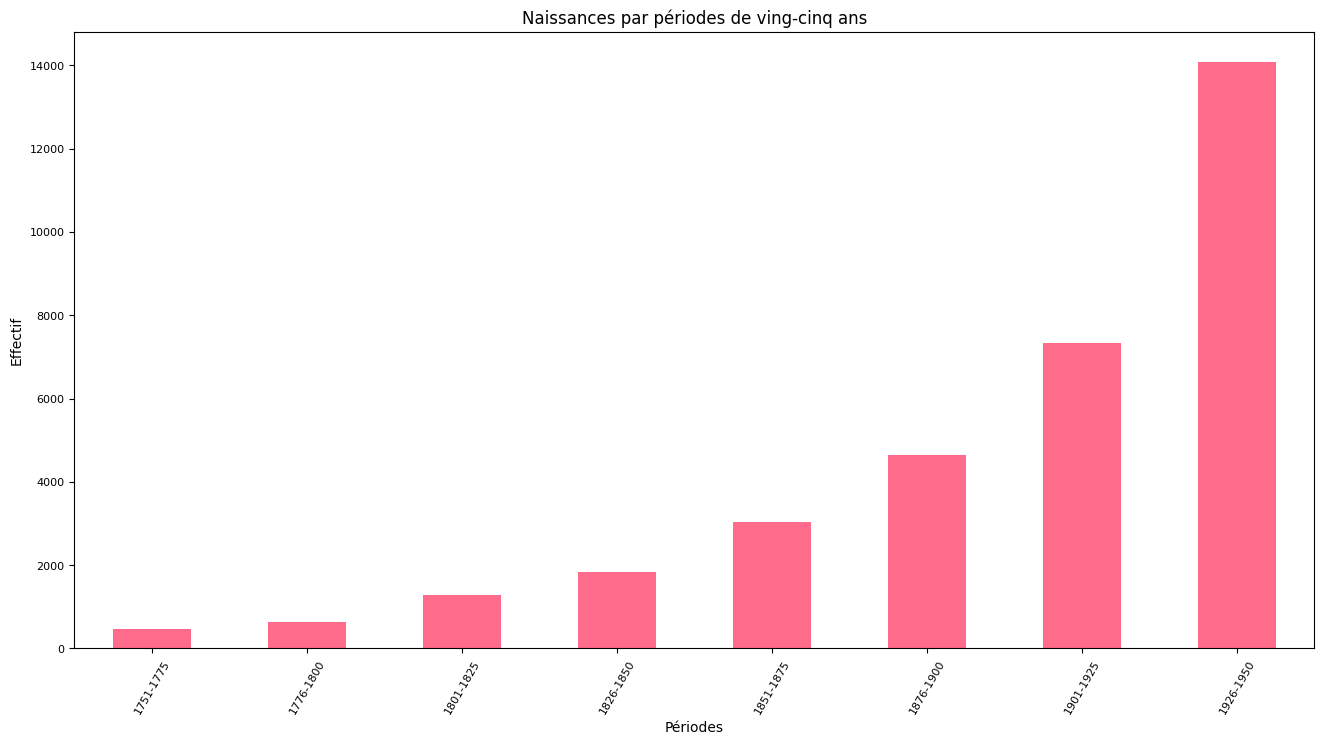

In [55]:
### Diagramme à barres représentant la distribution par 'génération'
ax = df_p.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8), color='#FF6B8B')
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

## Ajouter la représentation des continents

In [27]:
lcont = list(sorted(set(df_p.contCode.to_list())))
lcont.remove('Europe')
print(lcont)

['Africa', 'Asia', 'NorthAmerica', 'Oceania', 'SouthAmerica']


In [28]:
### Regrouper et compter avec un fitre sur le continent 'Europe'
merged = pd.DataFrame(df_p[df_p.contCode == 'Europe'].groupby('per_25').size())
merged.columns = ['Europe']
merged.tail()



/var/folders/b5/yh6_b6cs4vgfqd16nkxmhl9h0000gn/T/ipykernel_32866/2162464101.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged = pd.DataFrame(df_p[df_p.contCode == 'Europe'].groupby('per_25').size())


,Europe
per_25,
1826-1850,1351
1851-1875,2037
1876-1900,2874
1901-1925,3577
1926-1950,6419


In [29]:
### Ajouter les distributions des autres continents
for cont in lcont:
    new_df = pd.DataFrame(df_p[df_p.contCode == cont].groupby('per_25').size())
    new_df.columns = [cont]
    merged = pd.merge(merged, new_df, left_index=True, right_index=True)

merged    
    

/var/folders/b5/yh6_b6cs4vgfqd16nkxmhl9h0000gn/T/ipykernel_32866/3178152777.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_df = pd.DataFrame(df_p[df_p.contCode == cont].groupby('per_25').size())
/var/folders/b5/yh6_b6cs4vgfqd16nkxmhl9h0000gn/T/ipykernel_32866/3178152777.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_df = pd.DataFrame(df_p[df_p.contCode == cont].groupby('per_25').size())
/var/folders/b5/yh6_b6cs4vgfqd16nkxmhl9h0000gn/T/ipykernel_32866/3178152777.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1751-1775,401,1,20,49,0,7
1776-1800,518,1,20,82,1,4
1801-1825,991,1,26,246,4,25
1826-1850,1351,1,40,388,11,39
1851-1875,2037,11,214,661,31,90
1876-1900,2874,32,603,954,51,122
1901-1925,3577,92,1342,1893,118,310
1926-1950,6419,337,2299,4223,239,569


In [30]:
### Transformer l'index en chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1751-1775,401,1,20,49,0,7
1776-1800,518,1,20,82,1,4
1801-1825,991,1,26,246,4,25
1826-1850,1351,1,40,388,11,39
1851-1875,2037,11,214,661,31,90
1876-1900,2874,32,603,954,51,122
1901-1925,3577,92,1342,1893,118,310
1926-1950,6419,337,2299,4223,239,569


In [51]:
# ### Adapter à l'ordre des colonnes
# col_palette_1 = [
#     "#DCDCDC",  # Gainsboro : Europe
#     "#A3C1DA",  # Light Blue : Africa
#     "#F4A261",  # Light Coral : Asia
#     "#cd5c5c",  # Indian Red : NorthAmerica
#     "#B2E0B2",  # Light Green : Oceania
#     "#F6E58D",  # Light Yellow : SouthAmerica
    
# ]

col_palette_1 = [
    "#FF9EB5",  # Baker-Miller Pink (soft pastel)  
    "#FF6B8B",  # Light Crimson (warm pink)
    "#FFACD5",  # Cotton Candy (lightest pink)
    "#A2E4B8",  # Mint Green (fresh contrast)
    "#FFD166",  # Pastel Yellow (sunny accent)
    "#8BD3E6"   # Sky Blue (cool balance)
]


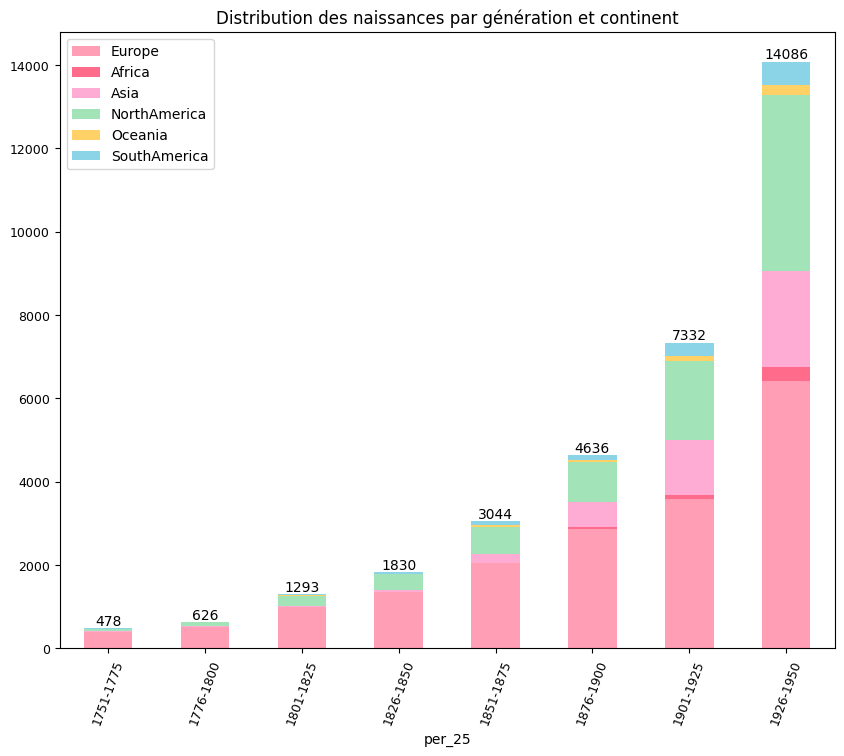

In [52]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = merged

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

## Représentation des mêmes informations avec une graphique décomposé




In [33]:
## L'information à représenter (la distribution des effectifs)
merged

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1751-1775,401,1,20,49,0,7
1776-1800,518,1,20,82,1,4
1801-1825,991,1,26,246,4,25
1826-1850,1351,1,40,388,11,39
1851-1875,2037,11,214,661,31,90
1876-1900,2874,32,603,954,51,122
1901-1925,3577,92,1342,1893,118,310
1926-1950,6419,337,2299,4223,239,569


In [34]:
### Fréquences par période
merged_prop = merged.apply(lambda x: (x / x.sum()) * 100, axis=1).round(1)
merged_prop

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1751-1775,83.9,0.2,4.2,10.3,0.0,1.5
1776-1800,82.7,0.2,3.2,13.1,0.2,0.6
1801-1825,76.6,0.1,2.0,19.0,0.3,1.9
1826-1850,73.8,0.1,2.2,21.2,0.6,2.1
1851-1875,66.9,0.4,7.0,21.7,1.0,3.0
1876-1900,62.0,0.7,13.0,20.6,1.1,2.6
1901-1925,48.8,1.3,18.3,25.8,1.6,4.2
1926-1950,45.6,2.4,16.3,30.0,1.7,4.0


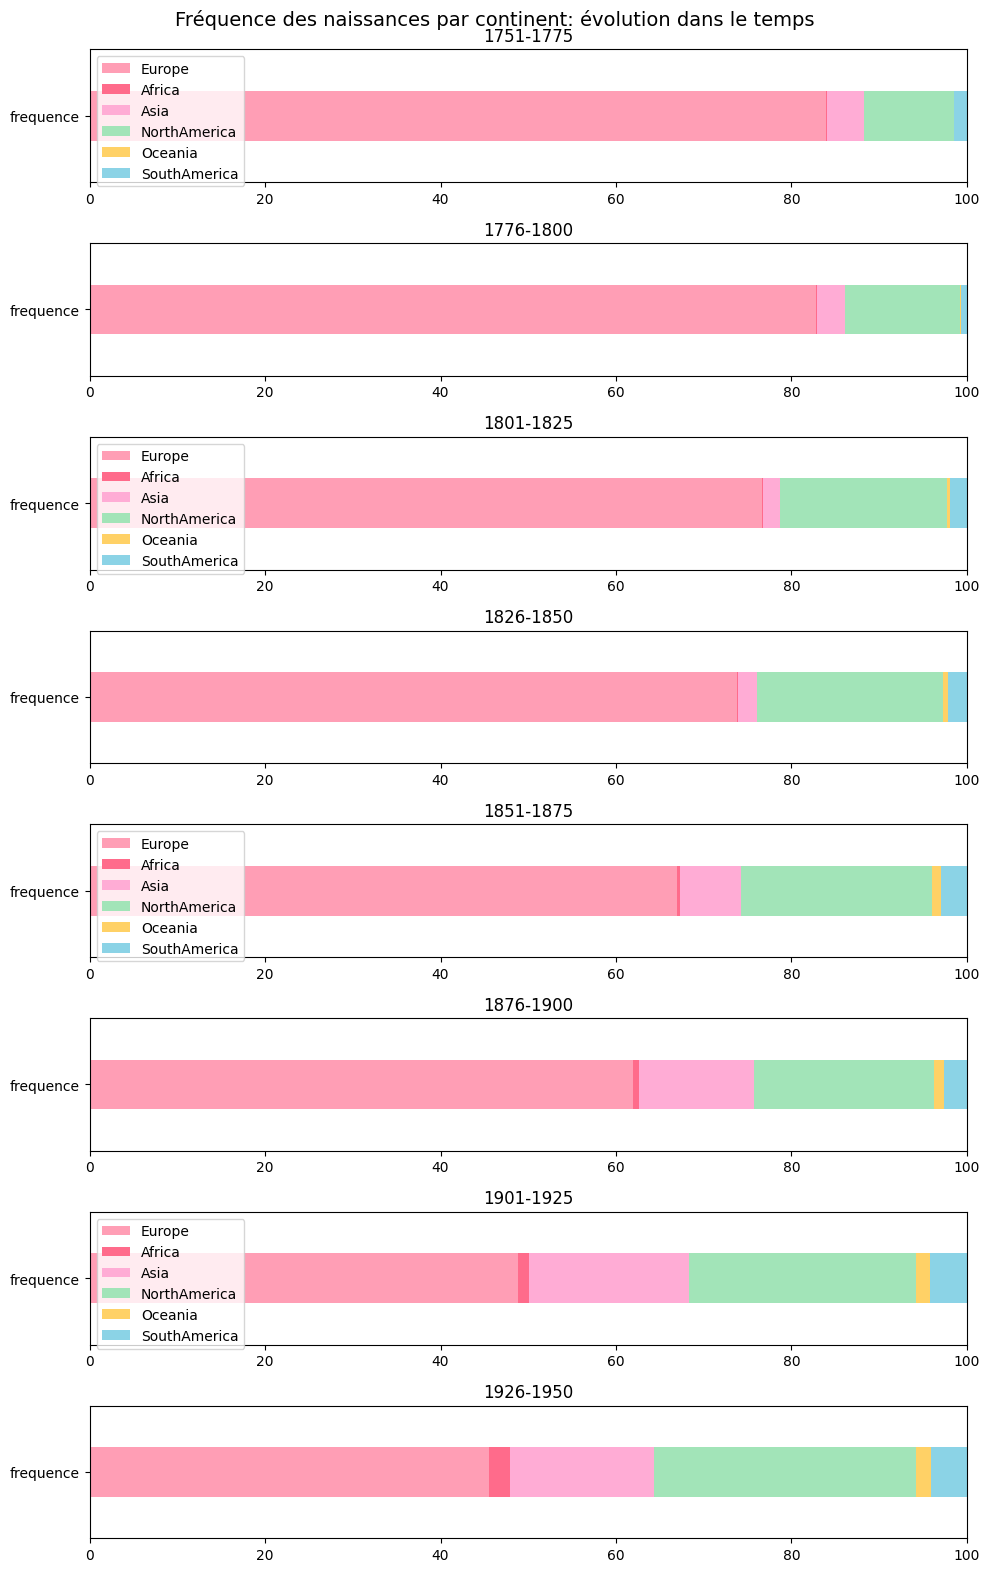

In [53]:
### Graphique multiple
#  Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/


lm = len(merged)

# Initialise the subplot function using number of rows and columns
#figure, axis = plt.subplots(lm, 1)

fig, axes = plt.subplots(lm, 1, figsize=(10,16))

i = 0

while i < lm:
    df = pd.DataFrame(merged.iloc[i , ])
    df['frequence'] = (100 * df / df.sum()).round(2)
    ljt = pd.DataFrame(df['frequence']).T
    # print(ljt)
    fig = ljt.plot(kind='barh', stacked=True, ax=axes[i], label=None, xlabel=None, 
                   fontsize=10, color=col_palette_1, width=0.3, xlim=[0,100])
    fig.set_title(df.columns[0])
    if (i+2)%2 != 0:
        fig.get_legend().remove()
    i += 1
    

plt.suptitle('Fréquence des naissances par continent: évolution dans le temps',  fontsize=14)
             
plt.tight_layout()  # rect=[0, 0.03, 1, 0.90]
plt.xlabel('')

   
plt.show()




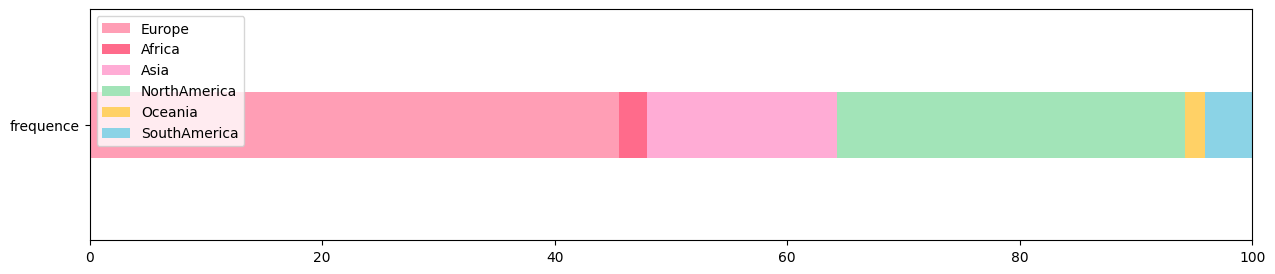

In [54]:

### Comparer avec l'ensemble de la période !
# Noter que la distribution  de la dernière tranche temporelle est quasiment la même pour l'ensemble de la période 
# du fait des effectifs très importants du 20e siècle, qui définissent la tendance générale

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette_1, width=0.2, xlim=[0,100])

